<a href="https://colab.research.google.com/github/amy-zyx/Data-Science-in-Action-R-Tools-and-Case-Studies/blob/master/Plexure_Analytics_Engineer_Technical_Exam_Amy_Zhou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PLEXURE: ANALYTICS ENGINEER TECHNICAL EXAM**

---
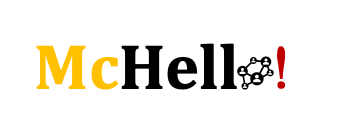

McHello! is a start-up social networking mobile application since January 2022 with a goal to create a platform where every user with same interest can easily connect and interact with each other. Currently, the platform has thousands of user across the globe, from Asia and Pacifics to South America.

One of the key measure of business success is the active users, and on a regular cycle the company needs to generate revenue amount per country depending on the number of users actively using the application.

**Problem Statement and Requirements**

Business Analysts need to create a report, dashboard and query ad-hoc data from the datasource. Currently, all relational datasource are on online transactional format making it harder to query data especially for non technical analysts and can cause miscalculations and misused of data.

As a key requirement, Analysts needs to have a source where data can easily be trusted and understand, with standardized and aggregated metrics and data model definitions as follows:

```
Aggregated Key Metrics:

1. Consumer Count - total unique user per action type
2. Active Consumer Revenue in USD - total generated revenue based on active users count.
Each count is equivalent to 1:5 value of the local currency.
For example, 1 action count is equal to 5 NZD in New Zealand.
Only user actions such as comment, post, like can generate revenue.
3. Consumer Count Ratio - total unique user per action type ratio to total count of all calendar days
4. Consumer Count Uplift - percent change of total unique user per action type from previous month

Granularity: Monthly
Entities: Be able to slice and dice with Country, User Actions, Monthly Date, and Currency Conversions.

Business stakeholders understand the data as activities instead of events and user instead of consumers.
Also, deactivated country is not useful for any report.
```
As An Analytics Engineer, create a physical model to meet the expectation and make data usage more effective and help to answer the questions.

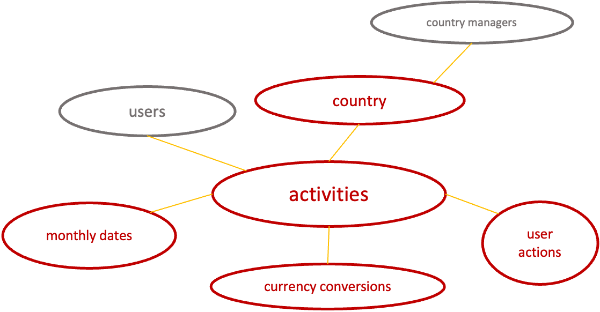



Part 1: Using the datasets below, and conceptual model, build a fact and dimension tables that consists the 5 entities such as activities, country, monthly dates, action types and currency conversions.




```
Events Table - Transaction log of all user activities with McHello!
Action_Type Table - Action Type code definitions
Consumer Table - Details of users historical data for both active and inactive
Currency Table - List of currency exchanges to USD for each country the app supports
Country Table - All countries where the application currently operates   
Country Manager Table- Application Manager for each country
```

```
Hint: All Dimensional Tables does not required SCD Key except for Currency due to volatility of exchange rates.
```


Part 2: Answer the following questions below with a query sourcing from the data model created and display the results.





For data preparation,

1. Upload all csv files in Collab, click on the folder icon -> Upload to session storage icon -> upload all 6 csv files. Data should be available in sampe_data folder.

2. execute the following steps below:
    
    2.1 #Inisialisation

    2.2 #Data Load into Table


In [ ]:
#Initialisation
%%capture
%pip install ipython-sql
import sqlite3
import pandas as pd
conn = sqlite3.connect('plexure.db')
%load_ext sql
%sql sqlite:///plexure.db

In [ ]:
#Data Load into Table
%%capture
events = pd.read_csv('events.csv')
events.to_sql('events', conn, if_exists='replace')
action_types = pd.read_csv('action_types.csv')
action_types.to_sql('action_types', conn, if_exists='replace')
consumers = pd.read_csv('consumers.csv')
consumers.to_sql('consumers', conn, if_exists='replace')
country = pd.read_csv('country.csv')
country.to_sql('country', conn, if_exists='replace')
country_manager = pd.read_csv('country_manager.csv')
country_manager.to_sql('country_manager', conn, if_exists='replace')
currency_conversions = pd.read_csv('currency_conversions.csv')
currency_conversions.to_sql('currency_conversions', conn, if_exists='replace')

PART 1: Build your physical model by creating each Fact and Dimension Tables, sample syntax below to create a table with SQLite

---





```
%%sql
CREATE TABLE <TABLE_NAME> AS
WITH CTE AS (
SELECT * FROM <TABLE_NAME SOURCE>)
SELECT * FROM CTE

```

```
Useful functions:
**Lag** - function accesses the value from the previous rows
on the basis of the defined offset in the function
**Row_Number** - window function that assigns a sequential integer
to each row within the partition of a result set
**Strftime** - function returns the date formatted according
to the format string specified in argument first

https://www.sqlitetutorial.net/

```

```
Hint: You can separate each table creation per cell
```

```
Note:
If you prefer python, feel free to use python dataframe instead of SQLite Table
in your physical model implementation and
python codes in generating results on Part 3 questions.
```



In [ ]:
#Hint on Creating Date Dimension
%%capture
%%sql
DROP TABLE IF EXISTS DIM_DATE;
CREATE TABLE DIM_DATE AS
-- Initiate the recursive loop
WITH RECURSIVE
-- Define a CTE to hold the recursive output
DateDimension (DateInterval)
AS
    (
        -- The start of recursion
        SELECT date('2021-07-01')
        UNION ALL
        SELECT date(DateInterval, '+24 hour') FROM DateDimension
        -- Limit the number of recursions
        LIMIT 1000
    )
SELECT DateInterval
FROM DateDimension;

In [159]:
%%sql
-- Country Dimension table
DROP TABLE IF EXISTS dim_country;
CREATE TABLE dim_country AS
             with cte    AS
             (
                             SELECT DISTINCT country,
                                             region
                             FROM            country
             )
SELECT row_number() over () AS countryid,
       country,
       region,
       CASE
              WHEN country IN
                               (
                               SELECT DISTINCT country
                               FROM            country_manager
                               WHERE           is_active = 1) THEN 1
              ELSE 0
       end AS isactive
FROM   cte;

-- Action Type Dimension table
DROP TABLE IF EXISTS dim_action_type;
CREATE TABLE dim_action_type AS
             with cte        AS
             (
                             SELECT DISTINCT action_type_code,
                                             action_type_description
                             FROM            action_types
             )
SELECT action_type_code AS action_type_id,
       action_type_description
FROM   cte;

-- Currency Dimension table
DROP TABLE IF EXISTS dim_currency_conversions;
CREATE TABLE dim_currency_conversions AS
             with cte                 AS
             (
                    SELECT country,
                           currency_code,
                           currency_conversion_type,
                           currency_exchange_rate,
                           insert_date
                    FROM   currency_conversions
             )
      SELECT row_number() over () AS currencyid,
             country,
             currency_code,
             currency_conversion_type,
             currency_exchange_rate,
             insert_date
      FROM   cte;

      --Country manager dimension table
DROP TABLE IF EXISTS dim_country_manager;
CREATE TABLE dim_country_manager AS
                   with cte            AS
                   (
                                   SELECT DISTINCT country_manager,
                                                   country,
                                                   country_segment,
                                                   is_active,
                                                   updated_date
                                   FROM            country_manager
                   )
   SELECT row_number() over () AS managerid,
          country_manager ,
          country,
          country_segment ,
          is_active,
          updated_date
   FROM   cte;

   --Country user dimension table
DROP TABLE IF EXISTS dim_user;
CREATE TABLE dim_user AS
                with cte AS
                (
                                SELECT DISTINCT user_id,
                                                c.country,
                                                deactivated,
                                                first_name,
                                                last_name,
                                                email,
                                                gender,
                                                postcode,
                                                [registration confirmation]
                                FROM            consumers c
                                INNER JOIN      country ct
                                ON              c.country = ct.country
                )
SELECT row_number() over () AS user_pk,
       user_id,
       country,
       deactivated,
       first_name,
       last_name,
       email,
       gender,
       postcode,
       [registration confirmation]
FROM   cte;

 * sqlite:///plexure.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [160]:
%%sql
--ACTIVITIES FACT TABLE
DROP TABLE IF EXISTS fact_activities;
CREATE TABLE fact_activities AS
             with cte        AS
             (
                        SELECT     e.activity_id,
                                   a.action_type_description,
                                   e.activity_time ,
                                   --e.item_id,
                                   e.device_type,
                                   c.user_id,
                                   c.country,
                                   md.dateinterval
                        FROM       events e
                        INNER JOIN dim_action_type a
                        ON         e.activity_code = a.action_type_id
                        INNER JOIN dim_date md
                        ON         date(e.activity_time) = md.dateinterval
                        INNER JOIN dim_user c
                        ON         e.consumer_id = c.user_id
             )
  SELECT row_number() over () AS activity_pk,
         activity_id,
         action_type_description,
         activity_time,
         -- item_id,
         device_type,
         user_id,
         country,
         dateinterval AS activity_date
  FROM   cte ;

 * sqlite:///plexure.db
Done.
Done.


[]

PART 2: Answer the following questions

---

1. What is the total revenue from Asia in 2023?
2. Display Country Manager from highest to Lowest in first quarter of 2023 based on active user counts
3. Display monthly user count ratio in New Zealand in 2023 for all comment action types, display with full month name.




In [167]:
#Answer
%%sql
----2. Active Consumer Revenue in USD - total generated revenue based on active users count.
----Each count is equivalent to 1:5 value of the local currency.
----For example, 1 action count is equal to 5 NZD in New Zealand.
----Only user actions such as comment, post, like can generate revenue.
SELECT Round(Sum(usd_revenue), 2) AS Total_USD_revenue_asia
FROM   (SELECT Count(action_type_description)                              AS
               count_,
               Count(action_type_description) * 5                          AS
                      Local_revenue,
               Count(action_type_description) * 5 * currency_exchange_rate AS
                      USD_revenue
        FROM   fact_activities f
               INNER JOIN dim_country c
                       ON f.country = c.country
               INNER JOIN dim_currency_conversions cc
                       ON f.country = c.country
        WHERE  activity_date BETWEEN '2023-01-01' AND '2023-12-31'
               AND action_type_description IN ( 'like', 'POST', 'comment' )
               AND c.region = 'Asia'
        GROUP  BY f.country)


 * sqlite:///plexure.db
Done.


Total_USD_revenue_asia
23245.61


In [168]:
#Answer
%%sql
--Display Country Manager from highest to Lowest in first quarter of 2023 based on active user counts
SELECT c.country_manager,
       c.country,
       Count(u.user_id) AS active_user_counts
FROM   dim_country_manager c
       INNER JOIN dim_user u
               ON c.country = u.country
       INNER JOIN fact_activities a
               ON u.user_id = a.user_id
WHERE  activity_date BETWEEN '2023-01-01' AND '2023-12-31'
       AND u.deactivated = 0
GROUP  BY c.country_manager
ORDER  BY 3 DESC

 * sqlite:///plexure.db
Done.


country_manager,country,active_user_counts
Ming Cheng,China,794
Jose Suarez,Argentina,536
Shiela Salamat,Philippines,398
Jacinda King,New Zealand,395
Miguel Diehl,Brazil,134


In [200]:
#Answer
%%sql
--Display monthly user count ratio in New Zealand in 2023 for all comment action types, display with full month name.
--3. Consumer Count Ratio - total unique user per action type ratio to total count of all calendar days
--4. Consumer Count Uplift - percent change of total unique user per action type from previous month
SELECT COUNT(distinct USER_ID) FROM fact_activities
where activity_date  between "2023-01-01" and "2023-12-31"
and action_type_description='comment'


 * sqlite:///plexure.db
Done.


COUNT(distinct USER_ID)
167


In [234]:
%%sql
--Display monthly user count ratio in New Zealand in 2023 for all comment action types, display with full month name.
--3. Consumer Count Ratio - total unique user per action type ratio to total count of all calendar days
--4. Consumer Count Uplift - percent change of total unique user per action type from previous month

SELECT COUNT(USER_ID) as count_,full_month, month_,sum(COUNT(USER_ID))over()as total_count, round(COUNT(USER_ID)*100.00/sum(COUNT(USER_ID))over(),2 )||' %'   as ratio_ from (
select distinct user_id,
rtrim (substr ('January--February-March----April----May------June-----July-----August---SeptemberOctober--November-December', strftime ('%m', activity_date) * 9 - 8, 9), '-') as full_month,strftime ('%m', activity_date) as month_,
count(DISTINCT user_id)
from fact_activities
where activity_date  between "2023-01-01" and "2023-12-31"
and action_type_description='comment'
group by user_id, action_type_description,rtrim (substr ('January--February-March----April----May------June-----July-----August---SeptemberOctober--November-December', strftime ('%m', activity_date) * 9 - 8, 9), '-')
) group by full_month
order by month_


 * sqlite:///plexure.db
Done.


count_,full_month,month_,total_count,ratio_
30,January,01,241,12.45 %
30,February,02,241,12.45 %
29,March,03,241,12.03 %
33,April,04,241,13.69 %
33,May,05,241,13.69 %
31,June,06,241,12.86 %
30,July,07,241,12.45 %
25,August,08,241,10.37 %
